In [14]:
!pip install scikit-activeml

In [15]:
import numpy as np
import pandas as pn

In [37]:
df = pn.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head(5)
df.isnull().sum()
df = df.dropna()

In [38]:
y = df['Class']
x= df.drop(['Class','Time','Amount'],axis=1)
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

#passive learning

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=42)
x, y = ros.fit_resample(x, y)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.4,random_state=42)
model = RandomForestClassifier(random_state=20)
model.fit(X_train,y_train)
print(y_train.shape)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
initial_accuracy

(590,)


0.9467005076142132

#process the unbalanced data


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.combine import SMOTEENN
ros = RandomUnderSampler(random_state=42)
x, y = ros.fit_resample(x, y)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.4,random_state=42)
y_test.value_counts()

Class
0    203
1    191
Name: count, dtype: int64

#margin sample`


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
import warnings
warnings.filterwarnings('ignore')

base_classifier = RandomForestClassifier(random_state=20)
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
active_learner = SklearnClassifier(estimator=base_classifier,classes=np.unique(y_train))
qs = UncertaintySampling(method='margin_sampling', random_state=42)
margin_cycles = []
margin_accuracy = []
margin_f1 = []
n_cycles = 20
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
print(y_train.shape)
active_learner.fit(X_train, y)
for c in range(n_cycles):
    query_idx = qs.query(X=X_train, y=y, clf=active_learner, batch_size=1)
    y[query_idx] = y_train.iloc[query_idx]
    active_learner.fit(X_train, y)
    y_pred = active_learner.predict(X_test)
    initial_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Initial Accuracy:", initial_accuracy)
    margin_cycles.append(c)
    margin_accuracy.append(initial_accuracy)
    margin_f1.append(f1)

(590,)
Initial Accuracy: 0.4847715736040609
Initial Accuracy: 0.8756345177664975
Initial Accuracy: 0.7944162436548223
Initial Accuracy: 0.9086294416243654
Initial Accuracy: 0.8883248730964467
Initial Accuracy: 0.8959390862944162
Initial Accuracy: 0.9111675126903553
Initial Accuracy: 0.9213197969543148
Initial Accuracy: 0.9060913705583756
Initial Accuracy: 0.7817258883248731
Initial Accuracy: 0.8071065989847716
Initial Accuracy: 0.916243654822335
Initial Accuracy: 0.9365482233502538
Initial Accuracy: 0.9289340101522843
Initial Accuracy: 0.9314720812182741
Initial Accuracy: 0.9263959390862944
Initial Accuracy: 0.9416243654822335
Initial Accuracy: 0.934010152284264
Initial Accuracy: 0.9416243654822335
Initial Accuracy: 0.9441624365482234


#query commite

In [21]:
base_classifier = RandomForestClassifier(random_state=20)
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
active_learner = SklearnClassifier(estimator=base_classifier,classes=np.unique(y_train))
qbc = QueryByCommittee()

qpc_cycles = []
qpc_accuracy = []
qpc_f1 =[]
n_cycles = 20
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
active_learner.fit(X_train, y)
for c in range(n_cycles):
    query_idx = qbc.query(X=X_train, y=y,ensemble=[active_learner], batch_size=1)
    y[query_idx] = y_train.iloc[query_idx]
    active_learner.fit(X_train, y)
    y_pred = active_learner.predict(X_test)
    initial_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Initial Accuracy:", initial_accuracy)
    qpc_cycles.append(c)
    qpc_accuracy.append(initial_accuracy)
    qpc_f1.append(f1)


Initial Accuracy: 0.5152284263959391
Initial Accuracy: 0.5152284263959391
Initial Accuracy: 0.7081218274111675
Initial Accuracy: 0.5532994923857868
Initial Accuracy: 0.7284263959390863
Initial Accuracy: 0.7842639593908629
Initial Accuracy: 0.9238578680203046
Initial Accuracy: 0.6725888324873096
Initial Accuracy: 0.6979695431472082
Initial Accuracy: 0.7030456852791879
Initial Accuracy: 0.6928934010152284
Initial Accuracy: 0.8121827411167513
Initial Accuracy: 0.8959390862944162
Initial Accuracy: 0.8705583756345178
Initial Accuracy: 0.8781725888324873
Initial Accuracy: 0.883248730964467
Initial Accuracy: 0.8883248730964467
Initial Accuracy: 0.9238578680203046
Initial Accuracy: 0.9060913705583756
Initial Accuracy: 0.9137055837563451


#least_confident

In [42]:
base_classifier =  RandomForestClassifier(random_state=20)
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
active_learner = SklearnClassifier(estimator=base_classifier,classes=np.unique(y_train))
qs = UncertaintySampling(method='least_confident', random_state=42)
least_cycles = []
least_accuracy = []
least_f1 =[]
n_cycles = 20
y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
print(y_train.shape)
active_learner.fit(X_train, y)
for c in range(n_cycles):
    query_idx = qs.query(X=X_train, y=y, clf=active_learner, batch_size=1)
    y[query_idx] = y_train.iloc[query_idx]
    active_learner.fit(X_train, y)
    y_pred = active_learner.predict(X_test)
    initial_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Initial Accuracy:", initial_accuracy)
    least_cycles.append(c)
    least_accuracy.append(initial_accuracy)
    least_f1.append(f1)

(590,)
Initial Accuracy: 0.4847715736040609
Initial Accuracy: 0.8756345177664975
Initial Accuracy: 0.7944162436548223
Initial Accuracy: 0.9086294416243654
Initial Accuracy: 0.8883248730964467
Initial Accuracy: 0.8959390862944162
Initial Accuracy: 0.9111675126903553
Initial Accuracy: 0.9213197969543148
Initial Accuracy: 0.9060913705583756
Initial Accuracy: 0.7817258883248731
Initial Accuracy: 0.8071065989847716
Initial Accuracy: 0.916243654822335
Initial Accuracy: 0.9365482233502538
Initial Accuracy: 0.9289340101522843
Initial Accuracy: 0.9314720812182741
Initial Accuracy: 0.9263959390862944
Initial Accuracy: 0.9416243654822335
Initial Accuracy: 0.934010152284264
Initial Accuracy: 0.9416243654822335
Initial Accuracy: 0.9441624365482234


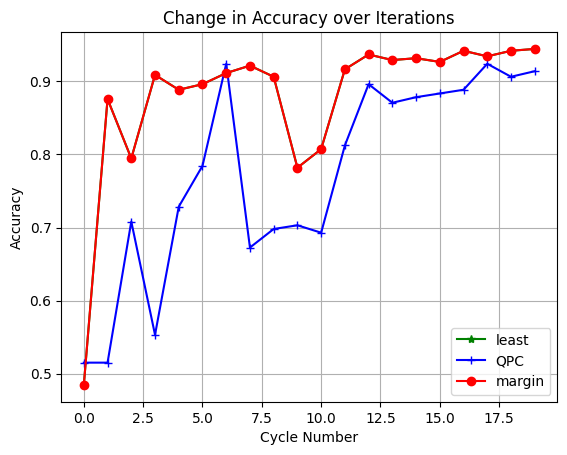

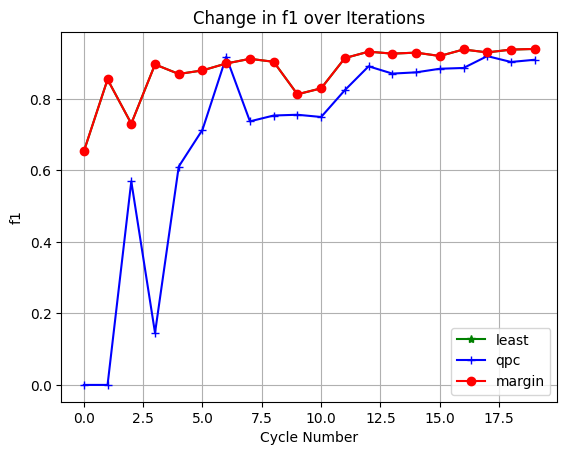

In [23]:
# accuracy
from matplotlib import pyplot as plt
plt.plot(least_cycles, least_accuracy, label='least',color='green',marker='*')
plt.plot(qpc_cycles, qpc_accuracy,label='QPC',color='blue',marker='+')
plt.plot(margin_cycles, margin_accuracy,label='margin',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()
#f1
plt.plot(least_cycles, least_f1, label='least',color='green',marker = '*')
plt.plot(qpc_cycles, qpc_f1,label='qpc',color='blue',marker='+')
plt.plot(margin_cycles, margin_f1,label='margin',color='red',marker = 'o')
plt.xlabel('Cycle Number')
plt.ylabel('f1')
plt.title('Change in f1 over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL
import numpy as np
import warnings


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=20)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
initial_accuracy

1.0

#balanced dataset


In [26]:



# Initialize base classifier
base_classifier = RandomForestClassifier(random_state=42)

# Initialize active learning classifier
active_learner = SklearnClassifier(estimator=base_classifier, classes=np.unique(y_train))

qs = UncertaintySampling(method='margin_sampling', random_state=42)

n_cycles = 20
margin_cycles = []
margin_accuracy = []
margin_f1 = []

y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)    # Initialize labels with MISSING_LABEL for active learning

# Fit active learning classifier with initial data
active_learner.fit(X_train, y)

# Active learning loop
for c in range(n_cycles):
    # Query indices from uncertainty sampling
    query_idx = qs.query(X=X_train, y=y, clf=active_learner, batch_size=1)

    # Label the queried instances
    y[query_idx] = y_train[query_idx]

    # Update active learning classifier with newly labeled instances
    active_learner.fit(X_train, y)
    # Predict labels for test data
    y_pred = active_learner.predict(X_test)
    initial_accuracy = accuracy_score(y_test, y_pred)
    margin_cycles.append(c)
    margin_accuracy.append(initial_accuracy)
    # Calculate and print accuracy
    print("Initial Accuracy after cycle {}: {:.4f}".format(c+1, initial_accuracy))


Initial Accuracy after cycle 1: 0.4222
Initial Accuracy after cycle 2: 0.7111
Initial Accuracy after cycle 3: 0.6444
Initial Accuracy after cycle 4: 0.7111
Initial Accuracy after cycle 5: 0.7556
Initial Accuracy after cycle 6: 0.8889
Initial Accuracy after cycle 7: 0.8222
Initial Accuracy after cycle 8: 0.8667
Initial Accuracy after cycle 9: 0.9778
Initial Accuracy after cycle 10: 1.0000
Initial Accuracy after cycle 11: 0.9556
Initial Accuracy after cycle 12: 0.9333
Initial Accuracy after cycle 13: 1.0000
Initial Accuracy after cycle 14: 0.9556
Initial Accuracy after cycle 15: 1.0000
Initial Accuracy after cycle 16: 1.0000
Initial Accuracy after cycle 17: 1.0000
Initial Accuracy after cycle 18: 1.0000
Initial Accuracy after cycle 19: 1.0000
Initial Accuracy after cycle 20: 1.0000


In [27]:
# Initialize base classifier
base_classifier = RandomForestClassifier(random_state=42)
qbc = QueryByCommittee()
# Initialize active learning classifier
active_learner = SklearnClassifier(estimator=base_classifier, classes=np.unique(y_train))
qbc_cycles = []
qbc_accuracy = []

n_cycles = 20

warnings.filterwarnings('ignore')

y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)    # Initialize labels with MISSING_LABEL for active learning


# Fit active learning classifier with initial data
active_learner.fit(X_train, y)

# Active learning loop
for c in range(n_cycles):
    # Query indices from uncertainty sampling
    query_idx = qbc.query(X=X_train, y=y,ensemble=[active_learner], batch_size=1)

    # Label the queried instances
    y[query_idx] = y_train[query_idx]
    print(y.shape)

    # Update active learning classifier with newly labeled instances
    active_learner.fit(X_train, y)

    # Predict labels for test data
    y_pred = active_learner.predict(X_test)

    # Calculate and print accuracy
    initial_accuracy = accuracy_score(y_test, y_pred)
    qbc_accuracy.append(initial_accuracy)
    qbc_cycles.append(c)


    print("Initial Accuracy after cycle {}: {:.4f}".format(c+1, initial_accuracy))

(105,)
Initial Accuracy after cycle 1: 0.2889
(105,)
Initial Accuracy after cycle 2: 0.7111
(105,)
Initial Accuracy after cycle 3: 0.7111
(105,)
Initial Accuracy after cycle 4: 0.7111
(105,)
Initial Accuracy after cycle 5: 0.9556
(105,)
Initial Accuracy after cycle 6: 1.0000
(105,)
Initial Accuracy after cycle 7: 1.0000
(105,)
Initial Accuracy after cycle 8: 1.0000
(105,)
Initial Accuracy after cycle 9: 0.9111
(105,)
Initial Accuracy after cycle 10: 1.0000
(105,)
Initial Accuracy after cycle 11: 1.0000
(105,)
Initial Accuracy after cycle 12: 1.0000
(105,)
Initial Accuracy after cycle 13: 1.0000
(105,)
Initial Accuracy after cycle 14: 1.0000
(105,)
Initial Accuracy after cycle 15: 1.0000
(105,)
Initial Accuracy after cycle 16: 1.0000
(105,)
Initial Accuracy after cycle 17: 1.0000
(105,)
Initial Accuracy after cycle 18: 1.0000
(105,)
Initial Accuracy after cycle 19: 1.0000
(105,)
Initial Accuracy after cycle 20: 1.0000


In [28]:
# Initialize base classifier
base_classifier = RandomForestClassifier(random_state=42)

# Initialize active learning classifier
active_learner = SklearnClassifier(estimator=base_classifier, classes=np.unique(y_train))

qs = UncertaintySampling(method='least_confident', random_state=42)

n_cycles = 20
least_cycles = []
least_accuracy = []

warnings.filterwarnings('ignore')

y = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)    # Initialize labels with MISSING_LABEL for active learning


# Fit active learning classifier with initial data
active_learner.fit(X_train, y)

# Active learning loop
for c in range(n_cycles):
    # Query indices from uncertainty sampling
    query_idx = qs.query(X=X_train, y=y, clf=active_learner, batch_size=1)

    # Label the queried instances
    y[query_idx] = y_train[query_idx]

    # Update active learning classifier with newly labeled instances
    active_learner.fit(X_train, y)

    # Predict labels for test data
    y_pred = active_learner.predict(X_test)

    # Calculate and print accuracy

    initial_accuracy = accuracy_score(y_test, y_pred)
    least_accuracy.append(initial_accuracy)
    least_cycles.append(c)
    print("Initial Accuracy after cycle {}: {:.4f}".format(c+1, initial_accuracy))

Initial Accuracy after cycle 1: 0.4222
Initial Accuracy after cycle 2: 0.7111
Initial Accuracy after cycle 3: 0.6444
Initial Accuracy after cycle 4: 0.7111
Initial Accuracy after cycle 5: 0.7556
Initial Accuracy after cycle 6: 0.8889
Initial Accuracy after cycle 7: 0.7778
Initial Accuracy after cycle 8: 0.8889
Initial Accuracy after cycle 9: 0.9333
Initial Accuracy after cycle 10: 0.9111
Initial Accuracy after cycle 11: 0.8889
Initial Accuracy after cycle 12: 0.9111
Initial Accuracy after cycle 13: 0.9556
Initial Accuracy after cycle 14: 0.9556
Initial Accuracy after cycle 15: 0.9778
Initial Accuracy after cycle 16: 0.9778
Initial Accuracy after cycle 17: 0.9778
Initial Accuracy after cycle 18: 1.0000
Initial Accuracy after cycle 19: 1.0000
Initial Accuracy after cycle 20: 0.9778


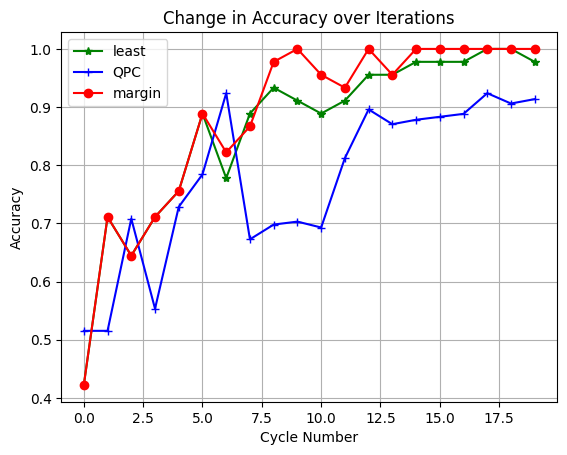

In [29]:
# accuracy
from matplotlib import pyplot as plt
plt.plot(least_cycles, least_accuracy, label='least',color='green',marker='*')
plt.plot(qpc_cycles, qpc_accuracy,label='QPC',color='blue',marker='+')
plt.plot(margin_cycles, margin_accuracy,label='margin',color='red',marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()
